In [8]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Configuração Básica para Mac M1
spark = SparkSession.builder \
    .appName("Exploracao_Gold_BeFly") \
    .config("spark.driver.memory", "2g") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Ler dados da Silver
# Atenção: O caminho é relativo ao local do notebook
df_silver = spark.read.parquet("../data/silver/flights_enriched")

print(f"Total de linhas na Silver: {df_silver.count()}")
df_silver.printSchema()

Total de linhas na Silver: 469968
root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)

In [9]:
# testar se conseguimos ranquear as piores empresas.
# Testando agregação por Companhia
df_kpi_airlines = df_silver.groupBy("AIRLINE_NAME").agg(
    F.count("*").alias("total_voos"),
    F.sum("CANCELLED").alias("voos_cancelados"),
    F.round(F.col("voos_cancelados") / F.col("total_voos") * 100, 2).alias("percentual_cancelamento"),
    F.round(F.avg("ARRIVAL_DELAY"), 2).alias("atraso_medio_chegada"),
    F.round(F.avg("DEPARTURE_DELAY"), 2).alias("atraso_medio_partida")
).orderBy(F.col("atraso_medio_chegada").desc())

df_kpi_airlines.show(25, truncate=False)

+----------------------------+----------+---------------+-----------------------+--------------------+--------------------+
|AIRLINE_NAME                |total_voos|voos_cancelados|percentual_cancelamento|atraso_medio_chegada|atraso_medio_partida|
+----------------------------+----------+---------------+-----------------------+--------------------+--------------------+
|Frontier Airlines Inc.      |6829      |89             |1.3                    |18.36               |17.98               |
|American Eagle Airlines Inc.|29900     |2288           |7.65                   |18.16               |16.08               |
|Spirit Air Lines            |8743      |98             |1.12                   |11.4                |13.15               |
|Skywest Airlines Inc.       |48114     |1262           |2.62                   |10.89               |12.16               |
|Atlantic Southeast Airlines |49925     |1702           |3.41                   |8.54                |9.75                |
|JetBlue

In [10]:
# 1. Primeiro fazemos as agregações básicas (Somas e Contagens)
df_kpi_airlines = df_silver.groupBy("AIRLINE_NAME").agg(
    F.count("*").alias("total_voos"),
    
    F.sum("CANCELLED").alias("voos_cancelados"),
    
    # Vamos contar quantos voos atrasaram (>15min)
    # Somamos 1 se for Delayed, 0 se não for
    F.sum(F.when(F.col("FLIGHT_STATUS") == "Delayed", 1).otherwise(0)).alias("voos_atrasados"),
    
    # Médias simples
    F.round(F.avg("ARRIVAL_DELAY"), 2).alias("atraso_medio_chegada"),
    F.round(F.avg("DEPARTURE_DELAY"), 2).alias("atraso_medio_partida")
)

# 2. Agora, fora do agg, calculamos as porcentagens
# Isso funciona porque 'total_voos', 'voos_cancelados' etc JÁ existem no DataFrame
df_kpi_final = df_kpi_airlines.withColumn(
    "percentual_cancelamento", 
    F.round((F.col("voos_cancelados") / F.col("total_voos")) * 100, 2)
).withColumn(
    "percentual_atraso", 
    F.round((F.col("voos_atrasados") / F.col("total_voos")) * 100, 2)
).orderBy(F.col("atraso_medio_chegada").desc())

df_kpi_final.show(25, truncate=False)

+----------------------------+----------+---------------+--------------+--------------------+--------------------+-----------------------+-----------------+
|AIRLINE_NAME                |total_voos|voos_cancelados|voos_atrasados|atraso_medio_chegada|atraso_medio_partida|percentual_cancelamento|percentual_atraso|
+----------------------------+----------+---------------+--------------+--------------------+--------------------+-----------------------+-----------------+
|Frontier Airlines Inc.      |6829      |89             |2091          |18.36               |17.98               |1.3                    |30.62            |
|American Eagle Airlines Inc.|29900     |2288           |9234          |18.16               |16.08               |7.65                   |30.88            |
|Spirit Air Lines            |8743      |98             |2283          |11.4                |13.15               |1.12                   |26.11            |
|Skywest Airlines Inc.       |48114     |1262           |1

In [11]:
# Testando cálculo de % de cancelamento
df_percentuais = df_silver.groupBy("AIRLINE_NAME").agg(
    F.count("*").alias("total"),
    F.sum("CANCELLED").alias("cancelados")
).withColumn(
    "taxa_cancelamento_pct", 
    F.round((F.col("cancelados") / F.col("total")) * 100, 2)
).orderBy(F.col("taxa_cancelamento_pct").desc())

df_percentuais.show(25, truncate=False)

+----------------------------+------+----------+---------------------+
|AIRLINE_NAME                |total |cancelados|taxa_cancelamento_pct|
+----------------------------+------+----------+---------------------+
|American Eagle Airlines Inc.|29900 |2288      |7.65                 |
|JetBlue Airways             |21623 |1102      |5.1                  |
|Atlantic Southeast Airlines |49925 |1702      |3.41                 |
|US Airways Inc.             |33489 |959       |2.86                 |
|Skywest Airlines Inc.       |48114 |1262      |2.62                 |
|United Air Lines Inc.       |38395 |967       |2.52                 |
|American Airlines Inc.      |44059 |900       |2.04                 |
|Southwest Airlines Co.      |100042|1767      |1.77                 |
|Virgin America              |4731  |80        |1.69                 |
|Frontier Airlines Inc.      |6829  |89        |1.3                  |
|Spirit Air Lines            |8743  |98        |1.12                 |
|Delta

In [12]:
# houve algum dia caótico em Janeiro de 2015?
df_diario = df_silver.groupBy("FLIGHT_DATE").agg(
    F.count("*").alias("total_voos"),
    F.sum("CANCELLED").alias("total_cancelados"),
    F.sum(F.when(F.col("FLIGHT_STATUS") == "Delayed", 1).otherwise(0)).alias("total_atrasados")
).orderBy("total_atrasados", ascending=False)

df_diario.show(31, truncate=False)

+-----------+----------+----------------+---------------+
|FLIGHT_DATE|total_voos|total_cancelados|total_atrasados|
+-----------+----------+----------------+---------------+
|2015-01-04 |16352     |433             |7645           |
|2015-01-03 |15434     |331             |6604           |
|2015-01-05 |16548     |435             |5480           |
|2015-01-06 |15315     |395             |5376           |
|2015-01-12 |15888     |436             |5282           |
|2015-01-02 |16741     |257             |4392           |
|2015-01-07 |15571     |303             |4201           |
|2015-01-09 |16008     |469             |4151           |
|2015-01-08 |16009     |813             |3667           |
|2015-01-11 |14754     |354             |3553           |
|2015-01-30 |16080     |114             |3333           |
|2015-01-01 |13950     |466             |2877           |
|2015-01-13 |15180     |197             |2609           |
|2015-01-21 |15525     |119             |2594           |
|2015-01-15 |1

# QA Gold Layer

In [13]:
# ==========================================
# CHECK-UP DA CAMADA GOLD (QA)
# ==========================================

print("--- 1. Validando KPIs por Companhia Aérea ---")
# Ler o diretório Parquet
path_airline = "../data/gold/airline_performance"

try:
    df_gold_airline = spark.read.parquet(path_airline)
    
    # Validação de Estrutura
    print(f"Total de Companhias: {df_gold_airline.count()}")
    df_gold_airline.printSchema()
    
    # Validação de Dados (Top 5 piores atrasos)
    print("Top 5 Companhias com maior atraso médio:")
    df_gold_airline.select(
        "AIRLINE_NAME", 
        "total_flights", 
        "cancellation_rate", 
        "avg_arrival_delay"
    ).show(5, truncate=False)
    
except Exception as e:
    print(f"ERRO ao ler Airline KPIs: {e}")
    print("Dica: Você rodou o script 'src/jobs/aggregate_gold.py'?")

print("\n" + "="*50 + "\n")

print("--- 2. Validando Resumo Diário ---")
path_daily = "../data/gold/daily_summary"

try:
    df_gold_daily = spark.read.parquet(path_daily)
    
    # Validação de Estrutura
    print(f"Dias processados: {df_gold_daily.count()}")
    
    # Validação de Dados (Ordenado por data)
    print("Resumo dos primeiros 5 dias de Janeiro:")
    df_gold_daily.orderBy("FLIGHT_DATE").show(5)
    
except Exception as e:
    print(f"ERRO ao ler Daily Summary: {e}")

--- 1. Validando KPIs por Companhia Aérea ---
Total de Companhias: 14
root
 |-- AIRLINE_NAME: string (nullable = true)
 |-- total_flights: long (nullable = true)
 |-- total_cancelled: long (nullable = true)
 |-- avg_arrival_delay: double (nullable = true)
 |-- total_delayed_flights: long (nullable = true)
 |-- cancellation_rate: double (nullable = true)
 |-- delay_rate: double (nullable = true)

Top 5 Companhias com maior atraso médio:
+----------------------------+-------------+-----------------+-----------------+
|AIRLINE_NAME                |total_flights|cancellation_rate|avg_arrival_delay|
+----------------------------+-------------+-----------------+-----------------+
|Frontier Airlines Inc.      |6829         |1.3              |18.36            |
|American Eagle Airlines Inc.|29900        |7.65             |18.16            |
|Spirit Air Lines            |8743         |1.12             |11.4             |
|Skywest Airlines Inc.       |48114        |2.62             |10.89       

/var/folders/gn/vxqsj2_5443blwyv0ck59psw0000gn/T/ipykernel_17032/74185091.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


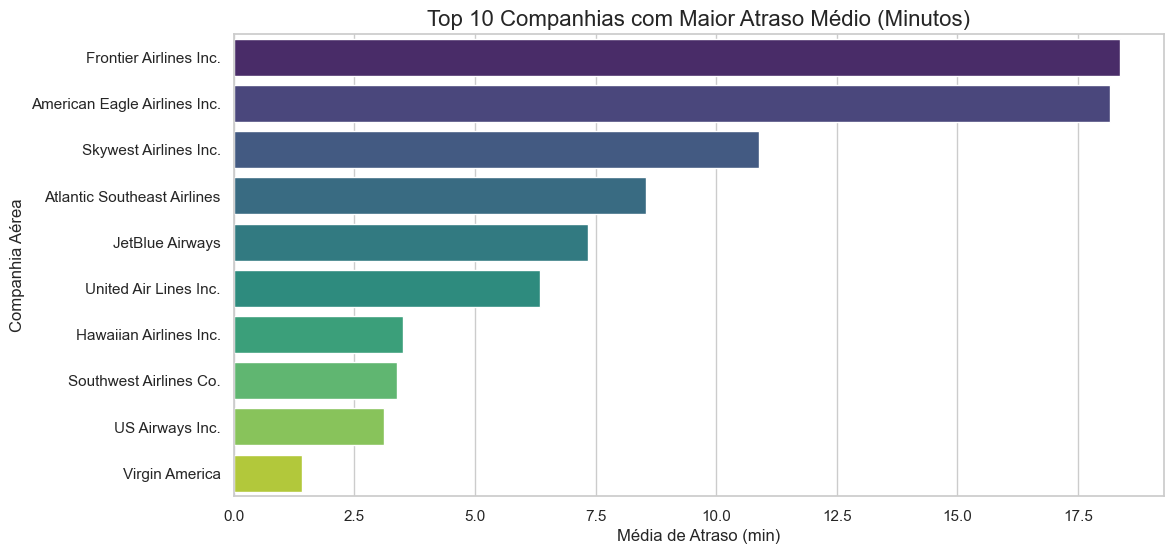

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Converter Spark DataFrame -> Pandas DataFrame
pdf_airlines = df_kpi_airlines.limit(10).toPandas()

# 2. Configurar o estilo
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 3. Criar Gráfico de Barras (Atraso Médio)
barplot = sns.barplot(
    x="atraso_medio_chegada", 
    y="AIRLINE_NAME", 
    data=pdf_airlines, 
    palette="viridis",
    order=pdf_airlines.sort_values("atraso_medio_chegada", ascending=False)["AIRLINE_NAME"]
)

plt.title("Top 10 Companhias com Maior Atraso Médio (Minutos)", fontsize=16)
plt.xlabel("Média de Atraso (min)", fontsize=12)
plt.ylabel("Companhia Aérea", fontsize=12)
plt.show()